In [2]:
import os
os.chdir(os.path.expanduser("~/Projects/zimmer"))
import copy
import pickle

import numpy as np
np.random.seed(1234)

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.ion()

from tqdm import tqdm
from functools import partial

from zimmer.io import load_nichols_data
import zimmer.plotting as zplt
from zimmer.observations import HierarchicalIndependentAutoRegressiveObservations, HierarchicalAutoRegressiveObservations,  HierarchicalRobustAutoRegressiveObservations
from zimmer.transitions import HierarchicalStationaryTransitions, HierarchicalRecurrentTransitions, HierarchicalRecurrentOnlyTransitions, HierarchicalNeuralNetworkRecurrentTransitions
from zimmer.util import cached

from ssm.models import HMM
from ssm.core import _HMM
from ssm.init_state_distns import InitialStateDistribution
from ssm.transitions import RecurrentTransitions, InputDrivenTransitions, StationaryTransitions, \
    NeuralNetworkRecurrentTransitions, RecurrentOnlyTransitions
from ssm.observations import IndependentAutoRegressiveObservations

from ssm.util import find_permutation, compute_state_overlap
from ssm.preprocessing import pca_with_imputation, trend_filter, standardize

In [3]:
# Specify hyperparameters
D = 10   # dimensionality of continuous latent states
M = 0    # dimensionality of input
results_dir = "results/nichols/2018-09-21/D{}".format(D)

In [4]:
worms_and_conditions = [(i, "n2_1_prelet") for i in range(11)] + \
                       [(i, "n2_2_let") for i in range(12)] + \
                       [(i, "npr1_1_prelet") for i in range(10)] + \
                       [(i, "npr1_2_let") for i in range(11)]
worm_names = ["{} worm {}".format(condition, i) for (i, condition) in worms_and_conditions]

groups = np.concatenate([
    0 * np.ones(11, dtype=int),
    1 * np.ones(12, dtype=int),
    2 * np.ones(10, dtype=int),
    3 * np.ones(11, dtype=int)
])

In [5]:
# Load the data
ys, ms, us, z_trues, z_true_key, neuron_names = load_nichols_data(worms_and_conditions, worm_names, include_unnamed=False, signal="dff")

Only including named neurons.
73 neurons across all 44 worms


In [6]:
ys = [trend_filter(y) for y in ys]
# ys = [standardize(y, m) for y, m in zip(ys, ms)]
K_true = len(z_true_key)
N = ys[0].shape[1]
W = len(ys)
Ts = [y.shape[0] for y in ys]

In [7]:
for cname, zname in zip(zplt.color_names, z_true_key):
    print(cname, ":", zname )

windows blue : Quiescence
red : Forward
amber : Reversal
faded green : Ventral turn
dusty purple : Dorsal turn
orange : undefined turn


# Empirical covariance from dF/F

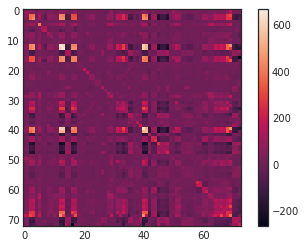

In [8]:
Ey = np.zeros((N,)) 
ny = np.zeros((N))
EyyT = np.zeros((N, N))
nyyT = np.zeros((N, N))
for y, m in zip(ys, ms):
    Ey += y.sum(0)
    ny += m.sum(0)
    EyyT += y.T.dot(y)
    nyyT += m.T.dot(m)

# Compute the empirical covariance
# Cov(y) = E[(y - Ey) (y - Ey)^T]
#        = E[yy^T] - Ey Ey^T
# assert np.all(nyyT > 0)
EyyT /= nyyT + 1e-8
Ey /= ny + 1e-8
C = EyyT - np.outer(Ey, Ey)

plt.figure()
plt.imshow(C)
plt.colorbar()


# Dimensionality reduction on $\Delta$F/F 

In [9]:
# Run PCA to get a 3d projection of the data
from ssm.preprocessing import pca_with_imputation
_pca = cached(results_dir, "pca")(pca_with_imputation)
pca, xs = _pca(D, ys, ms, num_iters=100)

In [10]:
# plt.figure(figsize=(12, 16))
# lim = 6
# w_to_plot=(0, 11, 23, 33)
# for i,w in enumerate(w_to_plot):
#     x = xs[w]
#     z= z_trues[w]
#     for d in range(1, 4):
#         ax = plt.subplot(4, 4, (d-1) * 4 + i+1)
#         zplt.plot_2d_continuous_states(x, z, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, d), ax=ax)
#         plt.ylabel("PC {}".format(d+1) if i == 0 else "")
#         plt.title(worm_names[w])

# plt.suptitle("Continuous Latent States (Zimmer Labels)")
# plt.tight_layout()

# Reconstruct from PCA

(-1, 1)

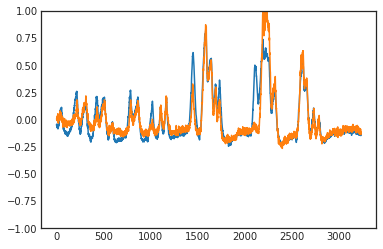

In [11]:
C = pca.components_.T
d = pca.mean_
y_hats = [x.dot(C.T) + d for x in xs]

n = 64

plt.plot(y_hats[0][:,n])
plt.plot(ys[0][:,n])
plt.ylim(-1, 1)

# Evaluate PCA component loadings

Cluster  0
AIBL
AIBR
AWBL
RIFR
SMDVR

Cluster  1
AFDL
AFDR
AVEL
AVER
OLQDL
OLQDR
OLQVL
OLQVR
SMDVL
VA02

Cluster  2
ALA
ASGL
ASGR
ASKR
AUAL
AUAR
AVFL
AVFR
AWAL
AWCL
AWCR
BAGL
BAGR
DB02
IL2L
RID
RMEL
RMER
RMGL
RMGR
SABVL
SABVR
SIBDL
SIBDR
SIBVL
SIBVR
SMBVL
VA01

Cluster  3
AVAL
AVAR
RIML
RIMR

Cluster  4
ASKL
RIFL

Cluster  5
SMDDL
SMDDR

Cluster  6
AVBL
AVBR
DB01
RIBL
RIBR
VB01
VB02
VB03

Cluster  7
RIVL
RIVR

Cluster  8
URYDL
URYDR
URYVL
URYVR

Cluster  9
AQR

Cluster  10
RIS
RMED
RMEV

Cluster  11
IL2DL
IL2DR
URXL
URXR



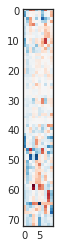

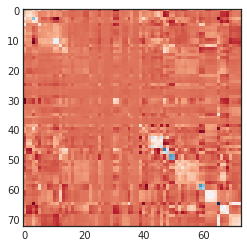

In [12]:
from sklearn.cluster import KMeans
C = pca.components_.T
km = KMeans(12)
km.fit(C)
Cp = C[np.argsort(km.labels_)]
plt.imshow(Cp, vmin=-abs(C).max(), vmax=abs(C).max(), cmap="RdBu")

plt.figure()
plt.imshow(Cp.dot(Cp.T), cmap="RdBu")

for k in range(km.n_clusters):
    print("Cluster ", k)
    for name in [name for kn, name in zip(km.labels_, neuron_names) if kn == k]:
        print(name)
        
    print("")

# Save the raw data

In [13]:
# with open(os.path.join(results_dir, "raw_data.pkl"), "wb") as f:
#     pickle.dump((ys, ms, neuron_names, us, worm_names), f)

# Split into train/test/validation

In [14]:
chunk = 250
train_frac = 0.7
val_frac = 0.15
all_ys = []
all_xs = []
all_ms = []
all_us = []
all_gs = []
all_tags = []
all_z_trues = []
all_choices = []
for tag, (y, x, m, u, g, ztr) in enumerate(zip(ys, xs, ms, us, groups, z_trues)):
    T = y.shape[0]
    C = 0
    for start in range(0, T, chunk):
        stop = min(start+chunk, T)
        all_ys.append(y[start:stop])
        all_xs.append(x[start:stop])
        all_ms.append(m[start:stop])
        all_us.append(u[start:stop])
        all_z_trues.append(ztr[start:stop])
        all_gs.append(g)
        all_tags.append(tag)
        C += 1
        
    # assign some of the data to train, val, and test
    choices = -1 * np.ones(C)
    choices[:int(train_frac * C)] = 0
    choices[int(train_frac * C):int((train_frac + val_frac) * C)] = 1
    choices[int((train_frac + val_frac) * C):] = 2
    choices = choices[np.random.permutation(C)]
    all_choices.append(choices)

all_choices = np.concatenate(all_choices)
get = lambda arr, chc: [x for x, c in zip(arr, all_choices) if c == chc]

train_ys = get(all_ys, 0)
train_xs = get(all_xs, 0)
train_ms = get(all_ms, 0)
train_us = get(all_us, 0)
train_zs = get(all_z_trues, 0)
train_tags = get(all_gs, 0)
# train_tags = get(all_tags, 0)

val_ys = get(all_ys, 1)
val_xs = get(all_xs, 1)
val_ms = get(all_ms, 1)
val_us = get(all_us, 1)
val_zs = get(all_z_trues, 1)
val_tags = get(all_gs, 1)
# val_tags = get(all_tags, 1)

test_ys = get(all_ys, 2)
test_xs = get(all_xs, 2)
test_ms = get(all_ms, 2)
test_us = get(all_us, 2)
test_zs = get(all_z_trues, 2)
test_tags = get(all_gs, 2)
# test_tags = get(all_tags, 2)

In [15]:
print("Training chunks per worm:   ", np.bincount(train_tags))
print("Validation chunks per worm: ", np.bincount(val_tags))
print("Testing chunks per worm:    ", np.bincount(test_tags))

Training chunks per worm:    [ 99 108  90  99]
Validation chunks per worm:  [22 24 20 22]
Testing chunks per worm:     [22 24 20 22]


In [16]:
# Compute number of training, validation, and test entries
D_train = sum([x.size for x in train_xs])
D_val = sum([x.size for x in val_xs])
D_test = sum([x.size for x in test_xs])

print("D_train: ", D_train)
print("D_val:   ", D_val)
print("D_test:  ", D_test)

D_train:  986120
D_val:    219550
D_test:   219450


# Fit an ARHMM to the continuous latent states, sweeping over number of discrete latent states

In [17]:
# Ks = np.arange(2, 21, step=2)
# transitionss = ["standard", "recurrent"]
# observationss = ["ar", "robust_ar"]

In [18]:
Ks = [2, 4, 6, 8, 10, 12, 14]
# Ks = np.arange(2, 21, step=2)
transitionss = ["recurrent"]
observationss = ["robust_ar"]

In [19]:
def _fit_hmm(K, transitions, observations):
    hmm = HMM(K, D, M, transitions=transitions, observations=observations)
    lps = hmm.fit(train_xs, method="em", num_em_iters=250)
    val_ll = hmm.log_likelihood(val_xs)
    return hmm, lps, val_ll

In [20]:
hmm_results = {}
for K in Ks:
    for transitions in transitionss:
        for observations in observationss:
            hmm_results_name = "hmm_{}_{}_K{}".format(transitions, observations, K)
            fit = cached(results_dir, hmm_results_name)(_fit_hmm)
            
            print("Fitting ", hmm_results_name)
            hmm_results[hmm_results_name] = fit(K, transitions, observations)
            
with open(os.path.join(results_dir, "hmm_results.pkl"), "wb") as f:
    pickle.dump(hmm_results, f)

Fitting  hmm_recurrent_robust_ar_K2
Fitting  hmm_recurrent_robust_ar_K4
Fitting  hmm_recurrent_robust_ar_K6
Fitting  hmm_recurrent_robust_ar_K8
Fitting  hmm_recurrent_robust_ar_K10
Fitting  hmm_recurrent_robust_ar_K12
Fitting  hmm_recurrent_robust_ar_K14


# Fit hierarchical HMMs

In [21]:
def _fit_hierarchical_hmm(K, transitions, observations, hmm):
    # Construct the HMM components
    init_state_distn = InitialStateDistribution(K, D, M)

    transition_classes = dict(standard=HierarchicalStationaryTransitions,
                              recurrent=HierarchicalRecurrentTransitions,
                              nn_recurrent=HierarchicalNeuralNetworkRecurrentTransitions)
    transition_distn = transition_classes[transitions](K, D, 4, M, eta=1e-4)
    
    observation_classes = dict(ar=HierarchicalAutoRegressiveObservations, 
                               independent_ar=HierarchicalIndependentAutoRegressiveObservations,
                               robust_ar=HierarchicalRobustAutoRegressiveObservations)
    observation_distn = observation_classes[observations](K, D, 4, M, eta=1e-4)
    
    # Construct the HMM
    hhmm = _HMM(K, D, M, init_state_distn, transition_distn, observation_distn)

    # Initialize with the standard HMM
    hhmm.init_state_distn.params = copy.deepcopy(hmm.init_state_distn.params)
    hhmm.transitions.initialize_from_standard(hmm.transitions)
    hhmm.observations.initialize_from_standard(hmm.observations)

    # Fit
    lps = hhmm.fit(train_xs, tags=train_tags, method="em", num_em_iters=250, initialize=False)
    
    # Validate
    val_ll = hhmm.log_likelihood(val_xs, tags=val_tags)
    return hhmm, lps, val_ll

In [22]:
hhmm_results = {}
for K in Ks:
    for transitions in transitionss:
        for observations in observationss:
            # Get the HMM results
            hmm_results_name = "hmm_{}_{}_K{}".format(transitions, observations, K)
            hmm, _, _ = hmm_results[hmm_results_name]
            
            # Fit the Hierarchical HMM
            hhmm_results_name = "hhmm_{}_{}_K{}".format(transitions, observations, K)
            fit = cached(results_dir, hhmm_results_name)(_fit_hierarchical_hmm)
            print("Fitting ", hhmm_results_name)
            hhmm_results[hhmm_results_name] = fit(K, transitions, observations, hmm)
            
with open(os.path.join(results_dir, "hhmm_results.pkl"), "wb") as f:
    pickle.dump(hhmm_results, f)

Fitting  hhmm_recurrent_robust_ar_K2
Fitting  hhmm_recurrent_robust_ar_K4
Fitting  hhmm_recurrent_robust_ar_K6
Fitting  hhmm_recurrent_robust_ar_K8
Fitting  hhmm_recurrent_robust_ar_K10
Fitting  hhmm_recurrent_robust_ar_K12
Fitting  hhmm_recurrent_robust_ar_K14


In [23]:
# # Plot train and validation likelihoods
# plt.figure(figsize=(6, 3))
# for transitions in transitionss:
#     for observations in observationss:
#         hmm_results_prefix = "hmm_{}_{}_".format(transitions, observations)
#         hmm_train_lls = [hmm_results[hmm_results_prefix + "K{}".format(K)][1][-1] for K in Ks]
#         plt.plot(Ks, hmm_train_lls, '-o', label=hmm_results_prefix)

#         hhmm_results_prefix = "hhmm_{}_{}_".format(transitions, observations)
#         hhmm_train_lls = [hhmm_results[hhmm_results_prefix + "K{}".format(K)][1][-1] for K in Ks]
#         plt.plot(Ks, hhmm_train_lls, '-o', label=hhmm_results_prefix)

# plt.xlabel("K")
# plt.xticks(Ks)
# plt.ylabel("Training Log Prob (with prior) ")
# plt.legend()

/home/scott/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


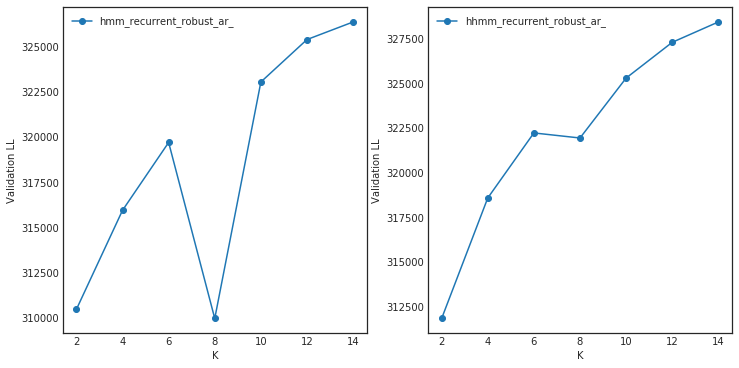

In [24]:
# Plot train and validation likelihoods

# num_bars = len(transitions) * len(observations)

plt.figure(figsize=(12, 6))
for transitions in transitionss:
    for observations in observationss:
        plt.subplot(121)
        hmm_results_prefix = "hmm_{}_{}_".format(transitions, observations)
        hmm_val_lls = [hmm_results[hmm_results_prefix + "K{}".format(K)][2] for K in Ks]
        plt.plot(Ks, hmm_val_lls, '-o', label=hmm_results_prefix)

        plt.subplot(122)
        hhmm_results_prefix = "hhmm_{}_{}_".format(transitions, observations)
        hhmm_val_lls = [hhmm_results[hhmm_results_prefix + "K{}".format(K)][2] for K in Ks]
        plt.plot(Ks, hhmm_val_lls, '-o', label=hhmm_results_prefix)

for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.xlabel("K")
    plt.xticks(Ks)
    plt.ylabel("Validation LL")
#     plt.ylim(43000, 47000)
    plt.legend()

# Fit the HHMM to the full train and validation data

In [25]:
def _fit_to_all_data(model):
    lps = model.fit(train_xs + val_xs, tags=train_tags + val_tags, method="em", num_em_iters=100, initialize=False)
    return model, lps

In [26]:
# # Fit the HMMs
# best_results = {}

# for transitions in transitionss:
#     for observations in observationss:
#         hmm_results_prefix = "hmm_{}_{}".format(transitions, observations)
#         hmm_val_lls = [hmm_results[hmm_results_prefix + "_K{}".format(K)][2] for K in Ks]
#         best_K = Ks[np.argmax(hmm_val_lls)]
        
#         # Fit the best model    
#         results_name = "best_" + hmm_results_prefix
#         print("Fitting ", results_name, " with K = ", best_K)
#         fit = cached(results_dir, results_name)(_fit_to_all_data)
#         hmm, _ = fit(hmm_results[hmm_results_prefix + "_K{}".format(best_K)][0])
        
#         # Compute the log likelihood of the test data
#         test_ll = hmm.log_likelihood(test_xs, tags=test_tags)
#         best_results[results_name] = (hmm, test_ll)
        
# # Fit the HHMMs
# for transitions in transitionss:
#     for observations in observationss:
#         hhmm_results_prefix = "hhmm_{}_{}".format(transitions, observations)
#         hhmm_val_lls = [hhmm_results[hhmm_results_prefix + "_K{}".format(K)][2] for K in Ks]
#         best_K = Ks[np.argmax(hhmm_val_lls)]
        
#         # Fit the best model    
#         results_name = "best_" + hhmm_results_prefix
#         print("Fitting ", results_name, " with K = ", best_K)
#         fit = cached(results_dir, results_name)(_fit_to_all_data)
#         hhmm, _ = fit(hhmm_results[hhmm_results_prefix + "_K{}".format(best_K)][0])
        
#         # Compute the log likelihood of the test data
#         test_ll = hhmm.log_likelihood(test_xs, tags=test_tags)
#         best_results[results_name] = (hhmm, test_ll)
        
# with open(os.path.join(results_dir, "best_results.pkl"), "wb") as f:
#     pickle.dump(best_results, f)

In [27]:
# # Plot train and validation likelihoods

# plt.figure(figsize=(12, 6))
# i = 0
# for transitions in transitionss:
#     for observations in observationss:
#         plt.subplot(121)
#         hmm_results_prefix = "best_hmm_{}_{}".format(transitions, observations)
#         plt.bar(i, best_results[hmm_results_prefix][1], label=hmm_results_prefix)
#         plt.ylim(300000, 330000)
        
#         plt.subplot(122)
#         hhmm_results_prefix = "best_hhmm_{}_{}".format(transitions, observations)
#         plt.bar(i, best_results[hhmm_results_prefix][1], label=hhmm_results_prefix)
#         plt.ylim(300000, 330000)
        
#         i += 1

# plt.subplot(121)
# plt.legend()

# Evaluate model fit

In [28]:
# hhmm, _ = best_results["best_hhmm_recurrent_ar"]

In [29]:
hhmm, _, _ = hhmm_results['hhmm_recurrent_robust_ar_K10']

In [30]:
hhmm.K

10

In [31]:
# Get the inferred states
z_infs = [hhmm.most_likely_states(x, tag=tag) for tag, x in zip(groups, xs)]
hhmm.permute(find_permutation(np.concatenate(z_trues), np.concatenate(z_infs)))
z_infs = [hhmm.most_likely_states(x, tag=tag) for tag, x in zip(groups, xs)]

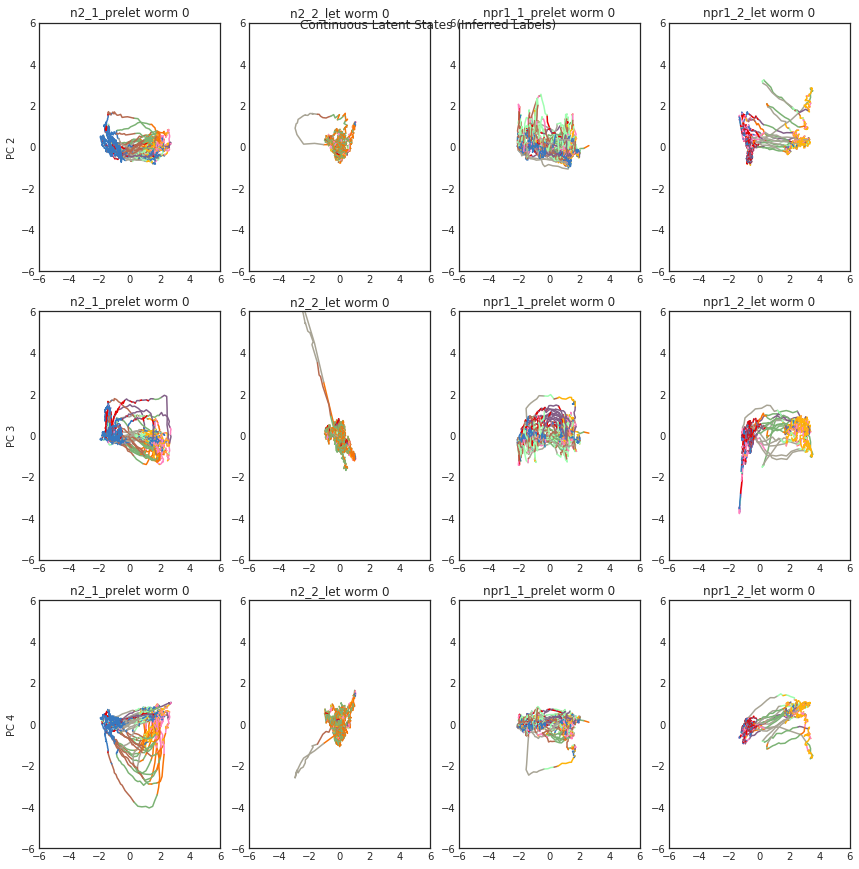

In [32]:
plt.figure(figsize=(12, 16))
lim = 6
w_to_plot=(0, 11, 23, 33)
for i,w in enumerate(w_to_plot):
    x = xs[w]
    z= z_infs[w]
    for d in range(1, 4):
        ax = plt.subplot(4, 4, (d-1) * 4 + i+1)
        zplt.plot_2d_continuous_states(x, z, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, d), ax=ax)
        plt.ylabel("PC {}".format(d+1) if i == 0 else "")
        plt.title(worm_names[w])

plt.suptitle("Continuous Latent States (Inferred Labels)")
plt.tight_layout()

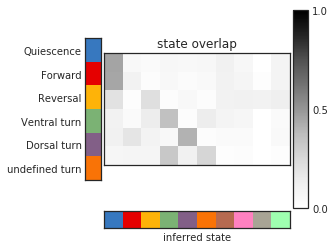

In [33]:
# Compute the overlap between inferred and true states
K_zimmer = len(z_true_key)
overlap = np.zeros((K_zimmer, hhmm.K), dtype=float)
for ww in range(W):
    for k1 in range(K_zimmer):
        for k2 in range(hhmm.K):
            overlap[k1, k2] += np.sum((z_trues[ww] == k1) & (z_infs[ww] == k2))

# Normalize the overlap from all worms and plot
overlap /= overlap.sum(1)[:, None]

fig = plt.figure(figsize=(4, 4))
gs = GridSpec(11, 12)

ax1 = fig.add_subplot(gs[:10, 1:11])
im = ax1.imshow(overlap, vmin=0, vmax=1.0, cmap="Greys", interpolation="nearest", aspect="equal")
ax1.set_yticks([])
ax1.set_xticks([])
ax1.set_title("state overlap")

lax = fig.add_subplot(gs[:10, 0])
lax.imshow(np.arange(K_zimmer)[:, None], cmap=zplt.default_cmap, 
              vmin=0, vmax=len(zplt.default_colors) - 1, aspect=1.5)

lax.set_xticks([])
lax.set_yticks(np.arange(K_zimmer))
lax.set_yticklabels(z_true_key)

bax = fig.add_subplot(gs[10, 1:11])
bax.imshow(np.arange(hhmm.K)[None, :], cmap=zplt.default_cmap,  aspect="auto",
           vmin=0, vmax=len(zplt.default_colors)-1)
bax.set_xticks([])
bax.set_yticks([])
bax.set_xlabel("inferred state")

axcb = fig.add_subplot(gs[:10, 11])
plt.colorbar(im, cax=axcb, ticks=[0, 0.5, 1])


# Simulate from the model

In [34]:
def simulate_model(name, model, pad=3, N_smpls=20):
    # Get the inferred states
    z_infs = [model.most_likely_states(x, tag=tag) for tag, x in zip(groups, xs)]
    model.permute(find_permutation(np.concatenate(z_trues), np.concatenate(z_infs)))
    z_infs = [model.most_likely_states(x, tag=tag) for tag, x in zip(groups, xs)]
    
    # Lower the noise
    model_low_noise = copy.deepcopy(model)
    model_low_noise.observations.inv_sigmas -= 4
    
    simulations = []

    for g in range(4):
        # Simulate N_smpls for this worm
        model_simulations_g = []
        for s in range(N_smpls):
            print("Model ", name, " Group ", g, " sample ", s)
            # Sample data
            Tsmpl = Ts[g*12]
            zpre, xpre = z_infs[g*12][-pad:], xs[g*12][-pad:]
            zsmpl, xsmpl = model_low_noise.sample(Tsmpl, prefix=(zpre, xpre), tag=g, with_noise=True)

            zsmpl = np.concatenate((zpre, zsmpl))
            xsmpl = np.concatenate((xpre, xsmpl))

            # Truncate to stable region
            unstable = np.arange(Tsmpl+pad)[np.any(abs(xsmpl) > 10, axis=1)]
            T_stable = np.min(np.concatenate(([Tsmpl+pad], unstable)))
            zsmpl = zsmpl[:T_stable]
            xsmpl = xsmpl[:T_stable]

            # Project into neural space
            ysmpl = xsmpl.dot(pca.components_) + pca.mean_

            # Append
            model_simulations_g.append((zsmpl, xsmpl, ysmpl))
            
        # Append this worm
        simulations.append(model_simulations_g)
        
    return simulations

In [35]:
simulations = {}
for name, (model, _) in best_results.items(): 
    print("Simulating ", name)
    _sim = cached(results_dir, name + "_sim")(simulate_model)
    simulations[name] = _sim(name, model)

NameError: name 'best_results' is not defined

In [ ]:
for g in range(4):
    plt.figure()
    ax = plt.subplot(111)
    for z, x, y in simulations["best_hhmm_recurrent_ar"][g][:2]:
        zplt.plot_2d_continuous_states(x, z, ax=ax, xlims=(-6, 6), ylims=(-6, 6))
#         plt.plot(x[:,0], x[:,1], color='k', alpha=0.5)

# Fit a model with inputs

In [ ]:
# Convert u into o2 and do2s
# E[u] = 13.6678;  std[u] = 5.185
def u_to_features(u, nlags=9):
    o2 = (u - 13.6678) / 5.185
    do2 = np.concatenate(([0], np.diff(o2)))
    
    features = [o2, do2]
    for lag in range(nlags):
        features.append(np.concatenate([np.zeros(lag), do2[lag:]]))
        
    return np.column_stack(features)

train_inputs = [u_to_features(u) for u in train_us]
val_inputs = [u_to_features(u) for u in val_us]
test_inputs = [u_to_features(u) for u in test_us]
M = test_inputs[0].shape[1]

In [ ]:
def _fit_hierarchical_hmm_with_inputs(K, transitions, observations, hmm):
    # Construct the HMM components
    init_state_distn = InitialStateDistribution(K, D, M)

    transition_classes = dict(standard=HierarchicalStationaryTransitions,
                              recurrent=HierarchicalRecurrentTransitions,
                              nn_recurrent=HierarchicalNeuralNetworkRecurrentTransitions)
    transition_distn = transition_classes[transitions](K, D, 4, M, eta=1)
    
    observation_classes = dict(ar=HierarchicalAutoRegressiveObservations, 
                               independent_ar=HierarchicalIndependentAutoRegressiveObservations,
                               robust_ar=HierarchicalRobustAutoRegressiveObservations)
    observation_distn = observation_classes[observations](K, D, 4, M, eta=1e-4)
    
    # Construct the HMM
    hhmm = _HMM(K, D, M, init_state_distn, transition_distn, observation_distn)

    # Initialize with the standard HMM
    # hhmm.init_state_distn.params = copy.deepcopy(hmm.init_state_distn.params)
    # hhmm.transitions.initialize_from_standard(hmm.transitions)
    # hhmm.observations.initialize_from_standard(hmm.observations)

    # Fit
    lps = hhmm.fit(train_xs, inputs=train_inputs, tags=train_tags, method="em", num_em_iters=250)
    
    # Validate
    val_ll = hhmm.log_likelihood(val_xs, inputs=val_inputs, tags=val_tags)
    return hhmm, lps, val_ll

In [ ]:
_fit = cached(results_dir, "hhmm_recurrent_ar_K8_inputs")(_fit_hierarchical_hmm_with_inputs)
irhhmm, lps, val_ll = _fit(8, "recurrent", "ar", hmm_results["hmm_recurrent_ar_K8"][0])

# Plot some segmentations

In [ ]:
# Get the inferred states
z_infs = [irhhmm.most_likely_states(x, tag=g) for g, x in zip(groups, xs)]
irhhmm.permute(find_permutation(np.concatenate(z_trues), np.concatenate(z_infs)))
z_infs = [irhhmm.most_likely_states(x, tag=g) for g, x in zip(groups, xs)]

In [ ]:
def make_figure_1(zs, w_to_plot=(1, 12, 24, 34), overlay=True, tmin=1, tmax=17):
    slc = slice(int(tmin*60*3), int(tmax*60*3+1))
    tslc = np.arange(int(tmin*60*3), int(tmax*60*3+1)) / 3.0 / 60.

    # Make plot
    fig = plt.figure(figsize=(13, 8))
    fig.patch.set_alpha(0)
    gs = GridSpec(3, len(w_to_plot), height_ratios=[12, 4, 1])

    for i, w in enumerate(w_to_plot):
        
        # Plot neural activity
        ax = fig.add_subplot(gs[0, i])
        
        if overlay:
            ax.imshow(zs[w][slc][None, :], 
                      vmin=0, vmax=len(zplt.default_colors)-1, 
                      cmap=zplt.default_cmap, 
                      aspect="auto", 
                      extent=(tmin, tmax, -N, 1), 
                      alpha=.25)
            
        ax.plot(tslc, (ys[w][slc] - np.arange(N)) * ms[w][slc], '-k', lw=0.5)
        ax.plot([6, 6], [-N, 1], '-k')
        ax.plot([12, 12], [-N, 1], '-k')
        
        if i == 0:
            ax.set_yticks(-np.arange(N))
            ax.set_yticklabels(neuron_names, fontsize=4)
            # ax.set_ylabel("Observed $\Delta$ F/F")
        else:
            ax.set_yticks([])
        ax.set_ylim(-N,1)
        ax.set_xlim(tmin, tmax)
        ax.set_xticks([])
        # ax.set_title("Worm {}".format(w+1))
        ax.set_title(worm_names[w])

        # Plot continuous latent states
        ax = fig.add_subplot(gs[1, i])
        
        if overlay:
            ax.imshow(zs[w][slc][None, :], 
                      vmin=0, vmax=len(zplt.default_colors)-1, 
                      cmap=zplt.default_cmap, 
                      aspect="auto", 
                      extent=(tmin, tmax, -D, 1), 
                      alpha=.25)
            
        ax.plot(tslc, (xs[w][slc]  * 0.25 - np.arange(D)), '-k', lw=0.5)
        ax.plot([6, 6], [-D, 1], '-k')
        ax.plot([12, 12], [-D, 1], '-k')
        
        if i == 0:
            ax.set_yticks(np.arange(0, -D, -1))
            ax.set_yticklabels(["dim {}".format(d+1) for d in range(D)], fontsize=6)
            # ax.set_ylabel("Continuous States")
        else:
            ax.set_yticks([])
        ax.set_ylim(-D,1)

        ax.set_xlim(tmin, tmax)
        ax.set_xticks([])

        # Plot discrete latent states
        ax = fig.add_subplot(gs[2, i])
        ax.imshow(zs[w][slc][None, :], vmin=0, vmax=len(zplt.default_colors)-1, cmap=zplt.default_cmap, aspect="auto", extent=(tmin, tmax, 0, 1))
        ax.plot([6, 6], [0, 1], '-k')
        ax.plot([12, 12], [0, 1], '-k')
        ax.set_ylim(0, 1)
        ax.set_yticks([])
        ax.set_xticks(np.arange(tmin, tmax+1))
        ax.set_xticklabels(np.arange(tmin, tmax+1), fontsize=6)
        ax.set_xlabel("time (min)")

    plt.tight_layout(pad=0.5)

make_figure_1(z_infs, overlay=True)
# make_figure_1(overlay=False)

In [ ]:
lim = abs(irhhmm.transitions.Ws).max()
for g in range(4):
    plt.figure()
    plt.imshow(irhhmm.transitions.Ws[g], vmin=-lim, vmax=lim, cmap="RdBu")
    plt.colorbar()
    